# Mathematical Modeling and Numerical Simulation of Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket 

## Darzi e.a. - Journal Hydrogen Energy 2016 

## Import Julia Packages 

In [7]:
using LinearAlgebra
using DifferentialEquations
using Plots

In [9]:
import Pkg; Pkg.add("StaticArrays")

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [90137ffa] + StaticArrays v1.9.13
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [10]:
# deliberately use include to include code 
# see e.g. https://docAs.julialang.org/en/v1/manual/code-loading/ 
include("flemish-fish.jl")

## Section 1: Introduction 

The <b>goals</b> of this notebook are:  
1. to reproduce the results by Darzi e.a. in their 2016 paper entitled <i>Absorption and Desorption of Hydrogen in Long Metal Hydride Tank Equipped with Phase Change Material Jacket</i>. This paper discusses the mathematical modeling and numerical simulation of metal-hydride materials for the storage (absorption (intake) and desorption (release)) of hygrogen gas. The [Van 't Hoff plot](https://en.wikipedia.org/wiki/Van_'t_Hoff_equation) is used to estimate the enthalpy (heat intake or release) and entropy of the chemical reaction of binding and release of hydrogen gas; 

1. <b>0D transient modeling</b>: to construct a zero-dimensional (perfectly stirred reactor) transient model for the storage (scenario-1) and release (scenario-2) of hydrogen gas from tank with and without MOFs. These models tracks the coupled time-evolution of two species. The first is the density of hydrogen gas density injected into the reactor. The second is the solid density (here intended as the amount of hydrogen gas absorbed by the MOF in the tank). The model is driven by a mass-flow rate. This mass-flow rate is linearly proportional to the solid density. Time stepping methods available in DifferentialEquations.jl will be used to solve these models.

1. <b>1D steady-state modeling</b>: to construct a one-dimensional stationary models for the storage (scenario-1) and release (scenario-2) of hydrogen gas from tank with (and without) MOFs. The model will consists of two submodels. The first submodel is a model for laminar non-isothermal flow of the hydrogen gas through the bed of metal-oxide material bed. This material bed will be modeled as a porous medium. This first submodel will consist of conservation of mass (diffusion equation for the pressure resulting in a pressure gradient over the reactor), conservation of momentum (convection-diffusion equation for the velocity) and conservation of energy. The second submodel is a model for the spatial and temporal variation of the hydrogen gas density and solid density. These models can be solved using shooting method available in DifferentialEquations.jl, finite difference methods implemented in FlemishFish.jl and finite element implemented in Ferrite.jl.

1. <b>1D transient modeling</b>: Extend previous models to transient case.   

1. collect information allowing an informed and critical discussion on future outlook with project partners;   

<img src="./darzi-2016-table1.png" width=800 />
Table-1 from Darzi-2016. 

More on the introduction will come later. 

<b>Next steps</b>
1. solve 0D-reactor using [this notebook](./zero-D-reactor-model.ipynb)
1. specify equations in the remainder of the notebook;
1. prepare rectangular 2D mesh geometry using GMSH for simulations using Ferrite.jl; 

## Section 2: 0D Transient Reactor Models 

### Section 1.2: Only Solid Density in Spatially Homogenous Reactor 

<b>Assumptions</b>: 
1. the reactor to be spatially homogeneous (well stirred reactor model, reactor has no spatial dimensions); 
1. pressure and temperature of reactor are constant; 
1. given empty bed density $\rho_{emp}$: see Table-1 for realistic value;  
1. saturated bed density $\rho_{sat}$: see Table-1 for realistic value?; 

<b>Problem Formulation</b>:

Model time-evolution of density of hydrogen gas bounded to the metal-oxide solid $\rho_s = \rho_s(t)$ in both absorption and desorption conditions, i.e, solve the (single) ordinary differential equation  

$$
(1 - \epsilon) \frac{d \, \rho_s}{dt} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} \,    
$$

where for <b>absorption</b> conditions (density of solid increases until reaching saturation)

$$
\dot{m}(\rho_s, t) = \dot{m}_a(\rho_s, t)
                   = C_a \exp(- \frac{E_a}{R \, T}) \, 
                        \log( \frac{p_p}{p_{eq,a}} ) \, (\rho_{sat} - \rho_s(t)) \, ,     
$$

and for <b>desorption</b> conditions (density decreases until reaching minimum value)

$$
\dot{m}(\rho_s, t) = \dot{m}_d(\rho_s, t)
                   = C_d \exp(- \frac{E_d}{R \, T}) \, 
                         ( \frac{p_p - p_{eq,d}}{p_{eq,d}} ) \, 
                         (\rho_s(t) - \rho_{emp}) \, ,       
$$

assuming final time to evolve between one and a few minutes. Observe that 
1. the mass flow rate $\dot{m}(\rho_s, t)$ is <i>independent</i> of the density of the gas $\rho_s(t)$;
1. the steady-state solution for absoroption and desorption is given by $\rho_s=\rho_{sat}$ and $\rho_s=\rho_{emp}$, respectively; 

<b>Coding</b>:

Code the problem set-up and solve using a suitable time-integration choosen from [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/). Plot time evolution of $\rho_s(t)$ and $\dot{m}$. Explore the sensitivity of the computed solution w.r.t. temperature and pressure operating conditions.   

<b>Scenario-1: Absorption Case</b> 
Here we model an absorption case. This case is seperable and can thus be solved analytically using seperation of variables, either using pen-and-paper and symbolic computations (using sympy e.g.). 

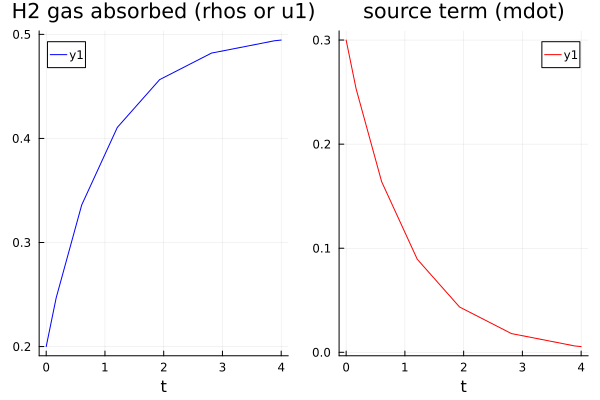

In [20]:
# problem set-up: rhs function that defines the ODE
function rhs(u,p,t)
    return (.5-u) # absorption assuming \rho_{sat} = 1 and multiplying factors equal 1
end 

# problem set-up: initial condition
u0 = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob = ODEProblem(rhs,u0,tspan)

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p1 = plot(sol.t, sol.u, xlabel = "t",line = :blue, title="H2 gas absorbed (rhos or u1)")

# post-process:evaluate and plot the source term 
p2 = plot(sol.t, rhs.(sol.u,1,sol.t),xlabel="t", line = :red, title="source term (mdot)")
plot(p1,p2,layout=(1,2))

<b>Scenario-2: Desorption Case</b> 
Here we model an desorption case.

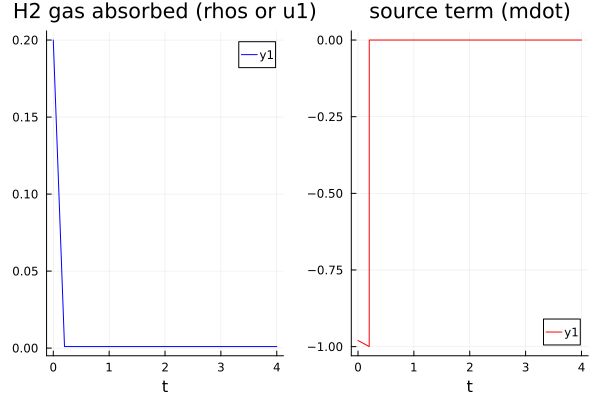

In [19]:
# problem set-up: rhs function that defines the ODE 
function rhs(u,p,t)
    return (0.1*u-1)*(u>0.001) # desorption assuming \rho_{emp} = 0.1 and rest equals 1 
end 

# problem set-up: initial condition 
u0 = .2;

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem 
prob = ODEProblem(rhs,u0,tspan)

# solve: perform time integration 
sol = solve(prob,AutoVern7(Rodas5()),reltol=1e-4,abstol=1e-4)

# post-process: plot computed solution 
p1 = plot(sol.t, sol.u, xlabel = "t",line = :blue, title="H2 gas absorbed (rhos or u1)")

# post-process:evaluate and plot the source term 
p2 = plot(sol.t, rhs.(sol.u,1,sol.t),xlabel="t", line = :red, title="source term (mdot)")
plot(p1,p2,layout=(1,2))

### Section 2.2: Coupled Solid/Gas Density in Spatially Homogenous Reactor

<b>Assumptions</b>: as before 

<b>Problem Formulation</b>:

Model time-evolution of hydrogen gas bounded to the metal-oxide solid $\rho_s = \rho_s(t)$ and density of the hydrogen gas $\rho_g = \rho_g(t)$  in both absorption and desorption conditions, i.e, solve the two ordinary differential equations coupled via the depency of the flow rate on the 

$$
(1 - \epsilon) \frac{d \, \rho_s}{dt} = \dot{m}(\rho_s, t) 
\text{ given } \rho_s(t = 0) = \rho_{s,0} \,    
$$

and 

$$
\epsilon \frac{d \, \rho_g}{dt} = - \dot{m}(\rho_s, t) 
\text{ given } \rho_g(t = 0) = \rho_{g,0} \, .     
$$

Not sure about signs in the equation. 

<b>Remarks</b>: what initial conditions make sense to use here? 

<b>Coding</b>: extend before from one to two coupled ordinary differential equations. 

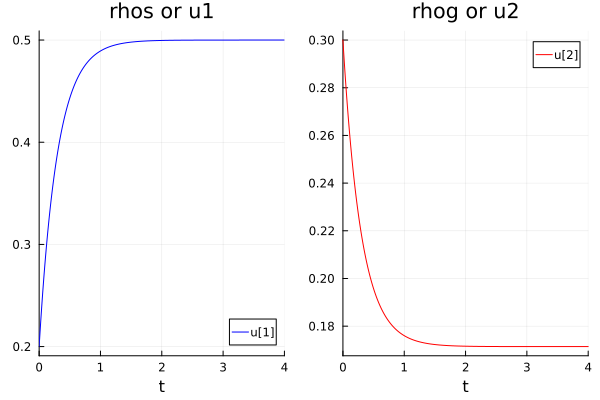

In [21]:
# problem set-up: rhs function that defines the ODE 
function rhs!(du,u,p,t)
 mdot = (.5-u[1])
 epsilon = 0.7 
 du[1] = mdot/(1-epsilon)
 du[2] = -mdot/epsilon 
end

# problem set-up: initial condition
u0 = [0.2,0.3] 

# problem set-up: set time span
Tend = 4
tspan = (0.0,Tend)

# problem set-up: define ODE problem
prob = ODEProblem(rhs!,u0,tspan)

# solve: perform time integration
sol = solve(prob)

# post-process: plot computed solution
p1 = plot(sol,idxs=1,line = :blue,title="rhos or u1")
p2 = plot(sol,idxs=2,line = :red,title="rhog or u2")
plot(p1,p2,layout = (1,2))

### Section 2.3: Pressure Evolution During Tank Fill / Emptying 

See [zero-D-reactor-model](zero-D-reactor-model.ipynb). 

## Section 3: One-Dimensional Reactor Models With A-Priori Given Axial Velocity 

<b>Assumptions</b>:
1. assume reactor to extend in space along the $z$-axis of a cylindrical coordinate system from $z=0$ to $z = 0.8 \, \text{m}$. 
2. assume $z$-axis to be discretized using either an uniform mesh or non-uniform mesh; 
3. for both the absorption and desorption case, assume the axial velocity $u_z(z)$ (in $\text{m}/\text{s}$) to be a given function of $z$. Examples include linear profiles for $u_z(z)$ (in positive $z$-direction for absorption and in negative $z$-direction for desorption) or solutions of the convection-diffusion equation for $u_z(z)$; 

<b>Problem Formulation</b>:

We assume the velocity $u_z(z)$ to be known (a-priori given). 

$$
(1 - \epsilon) \frac{\partial \, \rho_s}{\partial t} = \dot{m}(\rho_s, t) 
\text{ given initial conditions } \rho_s(t = 0) = \rho_{s,0} 
$$

and 

$$
\epsilon \frac{\partial \, \rho_g}{\partial t} = 
D \, \frac{\partial^2 \, \rho_g}{\partial z^2}
+ u_z \, \frac{\partial \, \rho_g}{\partial z} 
+ \dot{m}(\rho_s, t) 
\text{ given initial conditions } \rho_g(t = 0) = \rho_{g,0} 
\text{ and boundary conditions} \, .     
$$

In the stead-state case, only the convection-diffusion equation with a source term for $\rho_g(z)$ 

$$
D \, \frac{\partial^2 \, \rho_g}{\partial z^2}
+ u_z \, \frac{\partial \, \rho_g}{\partial z} 
+ \dot{m}(\rho_s, t) = 0 
\text{ given boundary conditions}     
$$

needs to be solved. 

<b>Weak or Variational Problem Formulation</b>: details to be filled in;

<b>Coding of Steady-State Problem</b>:

Assuming $u_z(z)$ to be known in either the case of absorption or desorption, the steady model can be solved using a shooting method, a finite difference method (using FlemishFish.jl) or a finite element method (using Ferrite.jl).  
 
<b>Coding of Set-up Phase of the Transient Problem</b>: 

For <b>discretization</b> in space: discretize the diffusion using second-order three-point finite difference stencil (tri-diagonal matrix $S$) and first-order two-point convection (bi-diagonal matrix $C$) operator using finite differences on a uniform mesh. See example of using FlemishFish.jl (in Section 5 of FlemishFish.ipynb - aslk Domenico for details). 

For <b>discretization</b> in time: using DifferentialEquations.jl as before. See e.g. [EE4375 course](https://github.com/ziolai/finite_element_electrical_engineering/tree/main) for examples. Or use e.g. [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) (observe that Ferrite ha no stabilization methods for convection dominated flows, assume no stabilization require for laminar flow through porous media); 

### Section 1.3: Steady State: Convection-Diffusion Equation for Gas Density $\rho_g$ or $u_2$

Use use [Ferrite](https://ferrite-fem.github.io/Ferrite.jl/stable/) in space to verify this solution. Implement weak, intermediate and strong convection.

In [29]:
# set source function 
src(x) = 0.  

# set right-hand side 
# u''(x) = - f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    rhog = u[1]; drhog = u[2]
    du[1] = drhog
    du[2] = -10*drhog + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    rhogleft = 1; rhogright=0; 
    residual[1] = u[1][1] - rhogleft 
    residual[2] = u[end][1] - rhogright
end

bc (generic function with 1 method)

In [30]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

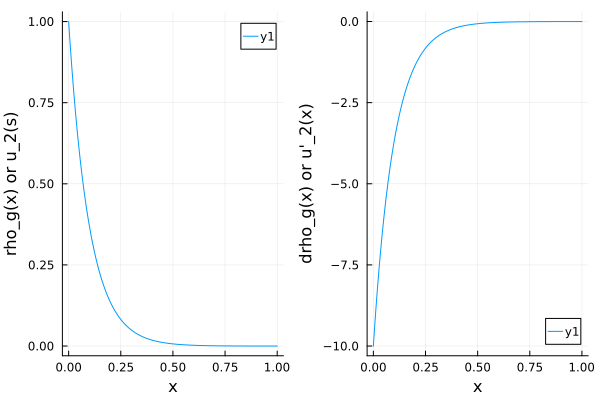

In [31]:
# plot u(x) and du/dx(x)
rhog  = [u[1] for u in sol.u]
drhog = [u[2] for u in sol.u]
p1 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x) or u_2(s)") 
p2 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x) or u'_2(x)") 
plot(p1,p2,layout=(1,2))

### Section 2.3: Transient State: Coupled Reaction-Convection-Diffusion for Solid $u_1$ and Gas $u_2$ Density

In [32]:
# spatial discretization 
N = (10,); Np1 = N[1]+1
m = fdmmesh(N)
A = stiffmat(m)
C = convectionmat(m);

In [33]:
# ODE model functions
function plug_flow_reactor!(du,u,p,t)
    Np1         = length(u) ÷ 2 
    rhos        = @view u[1:Np1]
    rhog        = @view u[Np1+1:end]
    mdot        = 1 .- rhos
    epsilon     = 0.5 
    du[1:Np1]  .= mdot/(1-epsilon)  
    du[Np1+1:end] .= -A*rhog - mdot/epsilon # .= A*rhog - mdot/epsilon  
    du[Np1+1] = 0; du[end] = 0 
end

# set initial conditions 
rhos0 = [.2 for xi in m[1]]
rhog0 = [.3 for xi in m[1]]; rhog0[1] = 0.; rhog0[end] = 0.;  
u0  = [rhos0; rhog0]

# set time interval 
tspan = (0.0,0.1)

# define and solve the problem 
prob = ODEProblem(plug_flow_reactor!,u0,tspan,p)
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8, save_everystep = true);

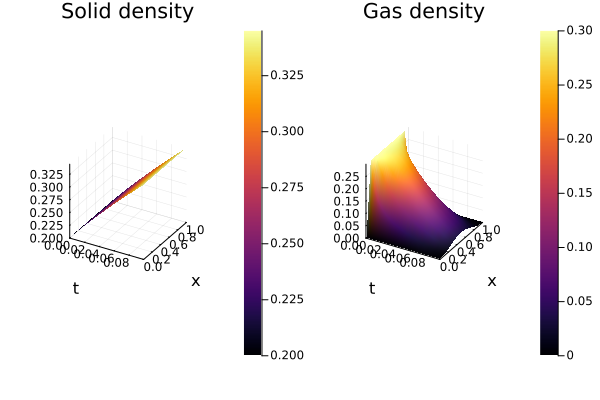

In [34]:
# post-processing 
rhosmat = reduce(hcat,[uti[1:Np1] for uti in sol.u])
rhogmat = reduce(hcat,[uti[Np1+1:end] for uti in sol.u])

p1 = surface(sol.t,m[1],rhosmat,xlabel="t", ylabel="x",title="Solid density")
p2 = surface(sol.t,m[1],rhogmat,xlabel="t", ylabel="x",title="Gas density")
plot(p1,p2,layout=(1,2))

## Section 4: More Advanced One-Dimensional Models for the Axial Velocity 

The <b>goal</b> of this section is to arrive at more realistic (non-linear and pressure driven) one-dimensional flow models for the axial velocity in case of filling and emptying the tank. 

The boundary of the tank consists of walls and inlet (in case of filling) and of walls on outlet (in case of emtying) 

<b> Questions: </b>
1. how to set the pressure and velocity boundary conditions in case of filling and emtying the tank? Using total pressure (cfr. Ansys Fluent Guide)?  See [this CFD online post by Paolo Lampitella](https://www.cfd-online.com/Forums/main/234508-how-properly-set-pressure-inlet-pressure.html)
1. how to use these flow models in the previous (Section 3) models for solid and gas density; 

### Section 1.4: Conservation of momentum 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$, given the pressure gradient $f(x)$ (we thus avoid solving for the pressure), given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) \text{ (conservation of momentum)}
$$

supplied with boundary conditions $u(x=0) = u_{in}$ (left boundary acts as an inlet velocity) and $u(x=0) = 0$ (right boundary condition acts as a wall)

In [13]:
# set source function 
src(x) = 1-x  

# set right-hand side 
# u''(x) + u'(x) = f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    du[1] = u[2]
    du[2] = 5*u[1]*u[2] + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    uleft = 1; uright=0; 
    residual[1] = u[1][1] - uleft 
    residual[2] = u[end][1] - uright
end

bc (generic function with 1 method)

In [14]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


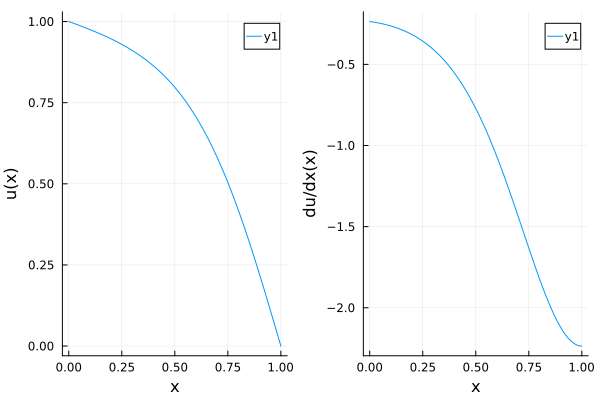

In [15]:
# plot u(x) and du/dx(x)
myv   = [u[1] for u in sol.u]
mydv  = [u[2] for u in sol.u]
rhog  = [u[3] for u in sol.u]
drhog = [u[4] for u in sol.u]
p1 = plot(sol.t, myv, xlabel="x", ylabel = "u(x)") 
p2 = plot(sol.t, mydv, xlabel="x", ylabel = "du/dx(x)") 
p3 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p4 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,p3,p4,layout=(2,2))

### Section 2.4: Conservation of mass - momentum 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$ and given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$ and pressure $p(x)$ (added stabilization terms in the conservation of mass)

$$
p''(x) = u'(x) \text{ (plus boundary conditions) (conservation of momentum)} 
$$

$$
u(x) \, u'(x) = 1/Re \, u''(x) + f(x) = 1/Re \, u''(x) - p'(x) \text{ (plus boundary conditions) (conservation of momentum)}
$$

supplied with the following boundary conditions. This model can again be implemented using a shooting method.

<b>Variational Problem Formulation</b>:

### Section 3.4: Conservation of mass - momentum - energy

1. add transport equation and source term ((de-)compression of gas) for the energy (enthalpy or temperature) to the previous model; 
1. add ideal gas law as equation of state; 

<b>Problem to solve</b> Given $x \in \Omega = (0,1)$ and given the Reynolds number $Re>0$, we intend to solve for the unknown velocity $u(x)$, pressure $p(x)$ and enthalpy (added stabilization terms in the conservation of mass)

## Section 5: One-Dimensional Model with More Realistic Flow Profile 
1D model for conservation of momentum and hydrogn gas transport

In [2]:
# set source function 
src(x) = 1-x  

# set right-hand side 
# u''(x) + u'(x) = f(x) reformulated as 
# coupled first order system as 
# u'(x) = v(x) and v'(x) = - f(x) or 
# du[1] = u[2] and du[2] = - f(x) 
function rhs!(du, u, p, x)
    v = u[1]; dv = u[2]; rhog = u[3]; drhog = u[4]
    du[1] = dv 
    du[2] = v*dv + src(x)
    du[3] = drhog
    du[4] = v*drhog + src(x)
end

# set boundary conditions 
# boundary conditions on the left and right of computational domain 
# requires explaining syntax 
function bc(residual, u, p, x)
    vleft = 1; vright=0; rhogleft = 1; rhogright=0;
    residual[1] = u[1][1] - vleft 
    residual[2] = u[end][1] - vright
    residual[3] = u[1][3] - rhogleft 
    residual[4] = u[end][3] - rhogright
end

bc (generic function with 1 method)

In [3]:
# set constants 
p = [1]

# set domain size 
xspan = (0.,1.)

# set initial guess 
start = [0., 0., 0., 0.]

# define and solve the problem 
bvp = BVProblem(rhs!, bc, start, xspan,p)
sol = solve(bvp, MIRK4(), dt = 0.005);

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


In [3]:
# plot u(x) and du/dx(x)
myv   = [u[1] for u in sol.u]
mydv  = [u[2] for u in sol.u]
rhog  = [u[3] for u in sol.u]
drhog = [u[4] for u in sol.u]
p1 = plot(sol.t, myv, xlabel="x", ylabel = "u(x)") 
p2 = plot(sol.t, mydv, xlabel="x", ylabel = "du/dx(x)") 
p3 = plot(sol.t, rhog, xlabel="x", ylabel = "rho_g(x)") 
p4 = plot(sol.t, drhog, xlabel="x", ylabel = "drho_g(x)") 
plot(p1,p2,p3,p4,layout=(2,2))

LoadError: UndefVarError: sol not defined

## Section 6: Geometry Modeling and Mesh Generation 

See seperate notebook [tankAndNozzle](tankAndNozzle.ipynb). 

## Section 7: Potential Flow in 2D Cylindrical Reactor

Solve Laplace Equation for the velocity potential and post-process for the axial ($u_z(r,z)$) and radial velocity ($u_r(r,z)$) components. Solve the Laplace using the mesh file tankAndNozzle.msh as input. Diffusive terms are neglected.    

See seperate notebook [potential_flow.ipynb](potential_flow.ipynb). 

## Section 8: Stokes Flow in 2D Cylindrical Reactor

Solve presssure-velocity coupling using Stokes flow model. Neglect non-linear convective terms. Adapt [Stokes Flow Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/stokes-flow/) to 2D cylindrical reaction. 

1. assemble on interior nodes: the 3 blocks (velocity-velocity, velocity-pressure and pressure-velocity) of the Stokes system;
1. assemble on the boundary nodes: velocity on the inlet, no-slip on the walls, pressure on the outlet. 
1. solve the Stokes system using LU decomposition; 
1. compare with closed tank (no outlet).  

## Section 9: Laminar Iso-Thermal Porous Media Flow (Pressure/Velocity) in Reactor 

The goal of this section is to implement a laminar flow model for the gas phase in the reactor filled with porous material.

Adapt [Ferrite Incompressible Navier-Stokes](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/ns_vs_diffeq/) to cylindrical reactor geometry and flow conditions;    

<b>Assumptions</b>: 

<b>Problem Formulation</b>: PDE + boundary conditions for inlet (fix velocity), outlet (fix pressure), wall (no slip) and symmetry;  

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 10: Solid/Gas Density in 2D Cylindrical Reactor with Porous Material  

Extend previous analysis from 1D space (only $x$) to 2D space (both $x$ and $y$). Assume a predefined velocity field for the gas phase velocity. Solve 2 coupled convection-diffusion-reaction equations for $\rho_s(x,y,t)$ and $\rho_g(x,y,t)$. 
1. Adapt [Ferrite Heat Equation Tutorial](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/heat_equation/) (steady state) from from one field to be solved to two fields to be solved for;
1. Similarly, adapt [transient_heat_equation](https://ferrite-fem.github.io/Ferrite.jl/stable/tutorials/transient_heat_equation/) from from one field to be solved to two fields to be solved for; 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 11: Laminar Non-Iso-Thermal Porous Media Flow in Reactor

Add heat effects to the flow field.  

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 12: Hydrogen Ab/Desorption in Reactor 

Ad hydrogen absorption and desorption to the model. 

<b>Assumptions</b>: 

<b>Problem Formulation</b>:

<b>Coding of Set-up Phase</b>: 

For <b>discretization</b> in space

For <b>discretization</b> in time 

<b>Coding of Set-up Phase</b>:

## Section 13: Conclusions 

## References 

1. Anoushka's work: [HydrogenProject.ipynb](https://github.com/AnouchkaDESMETTRE/HydrogenProject/blob/main/HydrogenProject.ipynb);